## ライブラリのインストールとインポート


In [3]:
%pip install -r requirements.txt


  Using cached heartpy-1.2.7-py3-none-any.whl (1.0 MB)
You should consider upgrading via the '/usr/local/bin/python3 -m pip install --upgrade pip' command.
Note: you may need to restart the kernel to use updated packages.


In [1]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
from scipy.io import loadmat
import seaborn as sns
import csv
import imageio
from scipy.signal import butter, filtfilt
import pywt
import ast
# import heartpy
from biosppy.signals import ecg
from scipy.signal import iirnotch, lfilter
from sklearn.model_selection import train_test_split
# from hrvanalysis import remove_outliers, remove_ectopic_beats, interpolate_nan_values

## 心電図データの取得
まずは、心電図センサーであるPolar H10を使用して、心電図を取得します。
Polar H10とPC間でBLE(Bluetooth Low Energy)通信を行い、データをcsv形式で保存します。
csvにはタイムスタンプと心電図をセットで取得するようにしています。

心拍変動解析を行う場合は、少ないデータでは行えない、解析結果の信頼性が落ちるという特徴があります。
医学的な HRV 解析ガイドラインでは，周波数解析を正確に行うには，RRI データを少なくとも 2 分間以上計測すること、および ECG サンプリング周波数は200Hz 以上とすることが推奨されています。{藤原 幸一:ヘルスモニタリングのための心拍変動解析}
ここで取得した心電図を用いて、心拍変動解析を行い、ストレス度を解析したいので、5分間ほど心電図を取得します。

*補足
ECGを取得中の様子で、csvファイルを二つ用意しています。
椅子に座り、安静にしている状態でECGを取得したものが、`CSV/ecg_calm.txt`です。
軽く上半身を中心に動かしている状態でECGを取得したものが、`CSV/ecg_excite.txt`です。
csvが2つ存在している理由は、安静にしている状態で取得した場合は、アーチファクトが起こりにくく、前処理を適用する理由が少なくなってしまうと考えたためです。
しかし、実際に作業していくものは、`CSV/ecg_calm.txt`です。
また、このコードを実行する場合は、JupyterNotebookでは、うまく作動しない可能性があるため、同じコードである`Heart_Rate_Analysis_from_Polar_H10.py`を実行することをおすすめします。


In [72]:
#このセクションでは、データ取得と解析に必要なライブラリをインポートします。`asyncio`はPythonで非同期プログラミングを行うための標準ライブラリで、タスクの同時実行を可能にします。`bleak`はBluetooth Low Energy (BLE) デバイスとの通信を扱うためのライブラリです。`numpy`は数値計算を効率的に行うためのライブラリで、データの保存や処理に使用します。`plotly.express`はデータの可視化を行うためのライブラリで、収集したデータの視覚的な解析を容易にします。
import asyncio
from bleak import BleakScanner, BleakClient
import numpy as np
import matplotlib.pyplot as plt

# 使用するデバイスの名前
POLAR_H10_NAME = "Polar H10 B91CE12A"  

# ECGデータストリームのUUID
#変更なし
PMD_SERVICE = "FB005C80-02E7-F387-1CAD-8ACD2D8DF0C8"
PMD_CONTROL = "FB005C81-02E7-F387-1CAD-8ACD2D8DF0C8"
PMD_DATA = "FB005C82-02E7-F387-1CAD-8ACD2D8DF0C8"
ECG_WRITE = bytearray([0x02, 0x00, 0x00, 0x01, 0x82, 0x00, 0x01, 0x01, 0x0E, 0x00])

ecg_session_data = []
ecg_session_time = []

#受信したデータの処理
def data_conv(sender, data):
    print("Data received")
    if data[0] == 0x00:
        timestamp = convert_to_unsigned_long(data, 1, 8)
        step = 3
        samples = data[10:]
        offset = 0
        while offset < len(samples):
            ecg = convert_array_to_signed_int(samples, offset, step)
            offset += step
            ecg_session_data.extend([ecg])
            ecg_session_time.extend([timestamp])

#指定されたオフセットと長さでデータを変換
def convert_array_to_signed_int(data, offset, length):
    return int.from_bytes(
        bytearray(data[offset : offset + length]), byteorder="little", signed=True,
    )

#指定されたオフセットと長さでデータを変換
def convert_to_unsigned_long(data, offset, length):
    return int.from_bytes(
        bytearray(data[offset : offset + length]), byteorder="little", signed=False,
    )


async def run():
    devices = await BleakScanner.discover()
    polar_h10_device = None

    # Polar H10デバイスの探索
    for device in devices:
        if device.name and POLAR_H10_NAME in device.name:
            print(f"Polar H10を見つけました: {device}")
            polar_h10_device = device
            break

    if not polar_h10_device:
        print("Polar H10が見つかりませんでした!")
        return

    # Polar H10デバイスとの接続とデータ取得
    async with BleakClient(polar_h10_device) as client:
        # 探索時間20秒間
        await client.connect(timeout=20.0)
        await client.write_gatt_char(PMD_CONTROL, ECG_WRITE)
        await client.start_notify(PMD_DATA, data_conv)
        # 5分間ECGデータを収集
        await asyncio.sleep(300.0)
        await client.stop_notify(PMD_DATA)
    
        # データ取得開始時に、大きなドリフトがあるので、最初の2秒のデータはカット
        ecg_cutted_session_data = ecg_session_data[:512]
        ecg_cutted_session_time = ecg_session_time[:512]

        # 収集したECGデータをファイルに保存
        np.savetxt("ecg_session_time.csv", ecg_cutted_session_time, delimiter=",")
        np.savetxt("ecg_session_data.csv", ecg_cutted_session_data, delimiter=",")
        print("ECGデータ保存")

        # ECGデータをプロット
        plt.figure(figsize=(10, 4))
        plt.plot(ecg_cutted_session_data)
        plt.title('ECG')
        plt.xlabel('Samples')
        plt.ylabel('Voltage (mV)')
        plt.tight_layout()
        plt.savefig("ecg_drift.png") 
        plt.show()


asyncio.run(run())

CSV files have been successfully saved.


## ECGの前処理

1つのcsvになったので、試しにplotしてみましょう
全てをplotすると横幅に対してデータが多すぎるるため、見にくいので一部をplotしてみます。

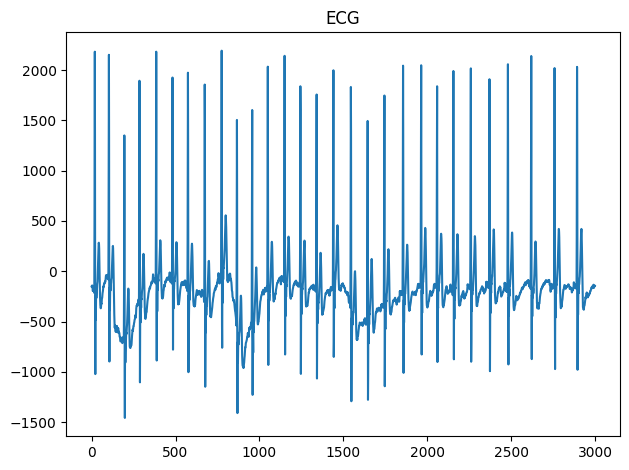

In [26]:
file_path = 'CSV/ecg_excite.txt'
#データの取得
data = np.loadtxt(file_path)
# 全体のデータの中で、アーチファクトがある部分
plt.plot(data[11000:14000])
plt.title('ECG')
plt.tight_layout()
plt.show()


上の図を見た時に、横の軸(下のコードセルの画像の赤線の部分)が少し上下にずれていることがわかると思います。<br>
この軸を「基線」というのですが、基軸が上下する(ドリフト・基線動揺と呼ぶ)と、取得したい目標のデータ以外がノイズとして入ってしまうアーチファクトが起きてしまう可能性が高くなります。<br>
そのため、前処理として、ドリフトを修正し、基軸が直線になるような処理を行う必要があります。<br>
心電図(ECG)のアーチファクトが起きている時の心電図の特徴と対処法をまとめると、以下のようになります。[2022年度新人サポート研修会臨床生理部門これだけは知っておいて欲しい心電図検査の基礎知識　p56-60(一部引用)]<br>



- 基線動揺(ドリフト)
    - 心電図の特徴
        - 心電図の基線が緩徐に上下する。(呼吸とともに上下する場合と呼吸とは無関係に上下する場合がある)
    - データ取得時の対処方法
        - 電極の接触誘導コードを確認する。
        - 被検者の不安を取り除き、リラックスしてもらうよう努める。
        - 部屋を温かくするなど空調を調節する。
        - 電極装着部位の皮膚を清拭し、汗をタオルでふく。
        - 電極に衣服がかからないようにする。
        - 検査前にトイレをすませてもらう。
    - データ処理時の対処方法
        - 心電データbior2.6 waveletを適用して、ECGからベースラインドリフトと筋電の干渉を除く
        - 時定数0.03秒のフィルタを適用する。*おすすめ
  	        - ドリフトは、超低周波の雑音である。
  	        - そこで、時定数が0.03秒の時定数は、5Hz 以下(周期0. 2秒以上)の成分は除去され低周波成分、例えばドリフトなど）の振幅を1/2に減衰することができる。基線の変動や低周波のノイズが抑制されるため、心電図（ECG）の信号がよりクリアになる。
- 筋電図混入
    - 心電図の特徴
        - 振幅、周波数ともに不規則な波が心電図に混入する。
    - データ取得時の対処方法
        - 被検者の不安を取り除き、リラックスしてもらうよう努める。
        - 寒さ対策として、空調調節やバスタオルなどをかける。
        - 背中が曲がっている場合は、足を折り曲げた状態で検査するとよい。
        - 四肢末端に震えがある場合は、四肢誘導の電極を中枢側に装着する。
        - 衣服を緩める。
        - 大きいベッドを使用する。
    - データ処理時の対処方法
        - 心電データbior2.6 waveletを適用して、ECGからベースラインドリフトと筋電の干渉を除く *おすすめ

- 交流障害(ハム)
    - 心電図の特徴
        - 50 Hz ~80 Hz の規則的な波が心電図に混入する。
    - データ取得時の対処方法
        - アースの接続状態を確認する。
        - 必要のない電気機器の電源コードを抜く。
        - 誘導コードをひとつにまとめる。
        - 併用機器との距離を離す。
        - 被検者とベッドの間に両面絶縁コーティングシールドシートを敷き、アース（1点）をとる。
        - 電極装着部位の皮膚を清拭し、汗をタオルでふく。
        - 電極の接触不良、錆び、汚れや混用がないことを確認する。
    - データ処理時の対処方法
        - 50 Hzと78 HzにThresholding Filters(閾値フィルター)を適用して、干渉を除く。*おすすめ



まず、基線動揺(ドリフト)に対する対処を行ないます。<br>
具体的には、時定数0.03秒のフィルタを適用します。<br>
時定数フィルタ0.03秒のフィルタでは、約5Hz 以下(周期0. 2秒以上)の成分の振幅を1/2に減衰することができます。<br>
そのため、ゆったりとした波であるドリフトを抑制することができます。<br>

In [16]:
# フィルタ設計用の関数
def design_highpass_filter(fs, cutoff_frequency):
    nyquist = 0.5 * fs
    normal_cutoff = cutoff_frequency / nyquist
    b, a = butter(1, normal_cutoff, btype='high', analog=False)
    return b, a

# 時定数からカットオフ周波数への変換
def time_constant_to_cutoff_frequency(time_constant):
    return 1 / (2 * np.pi * time_constant)

def plot_each_ecg(ecg_signal,filtered_ecg_0_03,filtered_ecg_1):
    plt.figure(figsize=(10, 8))
    plt.subplot(311)
    plt.plot(ecg_signal, label='Original ECG')
    plt.title('Original ECG Signal')
    plt.legend()
    plt.subplot(312)
    plt.plot(filtered_ecg_0_03, label='Filtered ECG (τ=0.03s)')
    plt.title('Filtered ECG with τ=0.03s')
    plt.legend()
    plt.subplot(313)
    plt.plot(filtered_ecg_1, label='Filtered ECG (τ=1s)')
    plt.title('Filtered ECG with τ=1s')
    plt.legend()
    plt.tight_layout()
    plt.show(block=False)
    input("Press Enter to continue...")
    plt.close()







次に、筋電図混入に対する対処を行います。<br>
具体的には、心電データに対して、bior2.6 waveletを適用して、筋電の干渉を除く関数を作ります。[Ancheng他]


In [17]:
# bior2.6フィルタの適用
def apply_bior2_6_filter(signal):
    """
    Uses bior2.6 wavelet decomposition to target and reduce EMG interference in ECG signals.
    
    Args:
    signal (array-like): The input ECG signal.
    fs (int): Sampling rate of the ECG signal.
    
    Returns:
    array-like: The signal with EMG interference reduced.
    """
    # ウェーブレットの選択
    wavelet = pywt.Wavelet('bior2.6')
    # 最大分解レベルの計算
    max_level = pywt.dwt_max_level(len(signal), wavelet.dec_len)
    # ウェーブレット分解
    coeffs = pywt.wavedec(signal, wavelet, level=max_level)
    
    # EMG干渉が想定される周波数成分を減衰させる
    # 通常、これらは中〜高周波数の詳細レベルに現れる
    # ここではレベル2からレベル4までの詳細係数を減衰させる
    # 減衰の度合いは実験的に調整が必要かもしれません
    for i in range(2, 5):
        coeffs[i] *= 0.5  # 係数を半減させることで干渉を減衰
    
    # ウェーブレット再構成
    filtered_signal = pywt.waverec(coeffs, wavelet)
    return filtered_signal

最後に、交流障害(ハム)についても対処していきます。<br>
この論文[Ancheng他]の中で、このデータセットに対して、50 Hzと78 HzにThresholding Filters(閾値フィルター)を使用して、干渉を除いているため、同様の処理を行います。


In [19]:
# 閾値フィルタの適用
def apply_notch_filters(signal, fs):
    f1 = 50
    f2 = 78
    
    # Quality factor
    Q = 30  # フィルターの鋭さ
    
    #50hzの閾値フィルターの作成と適用
    b1, a1 = iirnotch(f1, Q, fs)
    filtered_signal = lfilter(b1, a1, signal)
    
    b2, a2 = iirnotch(f2, Q, fs)
    filtered_signal = lfilter(b2, a2, filtered_signal)
    
    return filtered_signal

前処置を適用します。

In [18]:
'''
plot用
'''
def plot_time_constant_ecg(ecg_signal,filtered_ecg_0_03,filtered_ecg_1):
    plt.figure(figsize=(10, 8))
    plt.subplot(311)
    plt.plot(ecg_signal, label='Original ECG')
    plt.title('Original ECG Signal')
    plt.legend()
    plt.subplot(312)
    plt.plot(filtered_ecg_0_03, label='Filtered ECG (τ=0.03s)')
    plt.title('Filtered ECG with τ=0.03s')
    plt.legend()
    plt.subplot(313)
    plt.plot(filtered_ecg_1, label='Filtered ECG (τ=1s)')
    plt.title('Filtered ECG with τ=1s')
    plt.legend()
    plt.tight_layout()
    plt.show(block=False)
    plt.close()


def plot_wavelet_ecg(filtered_ecg_0_03,bior2_6_wavelet_ecg):
    plt.figure(figsize=(10, 8))
    plt.subplot(211)
    plt.plot(filtered_ecg_0_03, label='Filtered ECG (τ=0.03s)')
    plt.title('Filtered ECG with τ=0.03s')
    plt.legend()
    plt.subplot(212)
    plt.plot(bior2_6_wavelet_ecg, label='Original ECG')
    plt.title('Bior2.6 Wavelet ECG Signal')
    plt.legend()
    plt.tight_layout()
    plt.show(block=False)
    plt.close()


def plot_threshold_ecg(bior2_6_wavelet_ecg,threshold_ecg):
    plt.figure(figsize=(10, 8))
    plt.subplot(211)
    plt.plot(bior2_6_wavelet_ecg, label='Original ECG')
    plt.title('Bior2.6 Wavelet ECG Signal')
    plt.legend()

    plt.subplot(212)
    plt.plot(threshold_ecg, label='Threshold 50Hz 78Hz ECG')
    plt.title('Threshold 50Hz 78Hz ECG Signal')
    plt.legend()

    plt.tight_layout()
    plt.show(block=False)
    plt.close()



In [24]:
#新しいファイルへの書き込み
new_file_path = 'CSV/ecg_calm_preprocessed.txt'
# ヘッダーは書き込まない

# 心電図データのサンプリング周波数（Hz）
fs = 256
# 時定数0.03秒と1秒のカットオフ周波数
cutoff_freq_0_03 = time_constant_to_cutoff_frequency(0.03)
cutoff_freq_1 = time_constant_to_cutoff_frequency(1)
# フィルタの設計
b_0_03, a_0_03 = design_highpass_filter(fs, cutoff_freq_0_03)
b_1, a_1 = design_highpass_filter(fs, cutoff_freq_1)

# ECGの取得
file_path = 'CSV/ecg_calm.txt'
ecg_signal = np.loadtxt(file_path)

#時定数0.03秒・1秒のフィルタ
filtered_ecg_0_03 = filtfilt(b_0_03, a_0_03, ecg_signal)
filtered_ecg_1 = filtfilt(b_1, a_1, ecg_signal)

# bior2.6waveletフィルタ
bior2_6_wavelet_ecg = apply_bior2_6_filter(filtered_ecg_0_03)

# 50Hz,78Hzの閾値フィルタ
threshold_ecg = apply_notch_filters(bior2_6_wavelet_ecg, 256)

# 前処理を全て適用済
with open(new_file_path, 'w') as f:
    f.write(' '.join(['{:.18e}'.format(x) for x in threshold_ecg]))

## RRIの前処理

ECGデータからノイズとなるアーチファクトを取り除いた後、心拍変動解析を行うために、心電図からRR間隔を算出していきます。<br>
しかし、ここでもいくつかの前処理が必要になります。<br>
まず、前処理が必要になる理由を知るために、ECGデータからアーチファクトを除いたものからRRIを算出し、plotしましょう。<br>

In [51]:
'''
RR間隔(RRI)の計算
'''

def calculate_rri(signal, sampling_rate):
    # R波のピークの初期検出
    out = ecg.ecg(signal=signal, sampling_rate=sampling_rate, show=False)
    initial_rpeaks = out['rpeaks']

    # R波のピークの補正
    rpeaks_hamilton = ecg.correct_rpeaks(signal=signal, rpeaks=initial_rpeaks, sampling_rate=sampling_rate)

    # RRIの計算（ミリ秒単位）
    rri = np.diff(rpeaks_hamilton) * 1000 / sampling_rate
    return rri



何もRRIの前処理をしていないRR間隔(RRI)を計算し、csvにします。

In [55]:
#新しいファイルへの書き込み 
new_file_path = 'CSV/rri_calm.txt'
rri_list = []

#Polar H10のサンプリング周波数
fs = 130
# ECGの取得
file_path = 'CSV/ecg_calm.txt'  
ecg_signal = np.loadtxt(file_path)
print(ecg_signal)
# RRIの計算
rri_list = calculate_rri(ecg_signal,fs)

# 前処理を全て適用済
with open(new_file_path, 'w') as f:
    f.write(np.array2string(rri_list[0], precision=18, separator=' ', suppress_small=True))

[-242. -179. -304. ...    4.  426. 1291.]


plotします。

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


[ 815.38461538  807.69230769  769.23076923  746.15384615  738.46153846
  738.46153846  730.76923077  707.69230769  676.92307692  653.84615385
  646.15384615  676.92307692  769.23076923  984.61538462 1007.69230769
 1015.38461538  953.84615385  946.15384615  923.07692308  823.07692308
  815.38461538  807.69230769  807.69230769  769.23076923  938.46153846
 1053.84615385 1023.07692308 1000.          976.92307692  815.38461538
  815.38461538  800.          776.92307692  738.46153846  807.69230769
  892.30769231  838.46153846  761.53846154  715.38461538  738.46153846
  738.46153846  707.69230769  761.53846154  853.84615385  815.38461538
  869.23076923  961.53846154  976.92307692  915.38461538  907.69230769
  815.38461538  838.46153846  876.92307692  923.07692308  976.92307692
  869.23076923  761.53846154  792.30769231  846.15384615  884.61538462
  807.69230769  876.92307692  792.30769231  876.92307692  861.53846154
  776.92307692  838.46153846  876.92307692  861.53846154  769.23076923
  830.

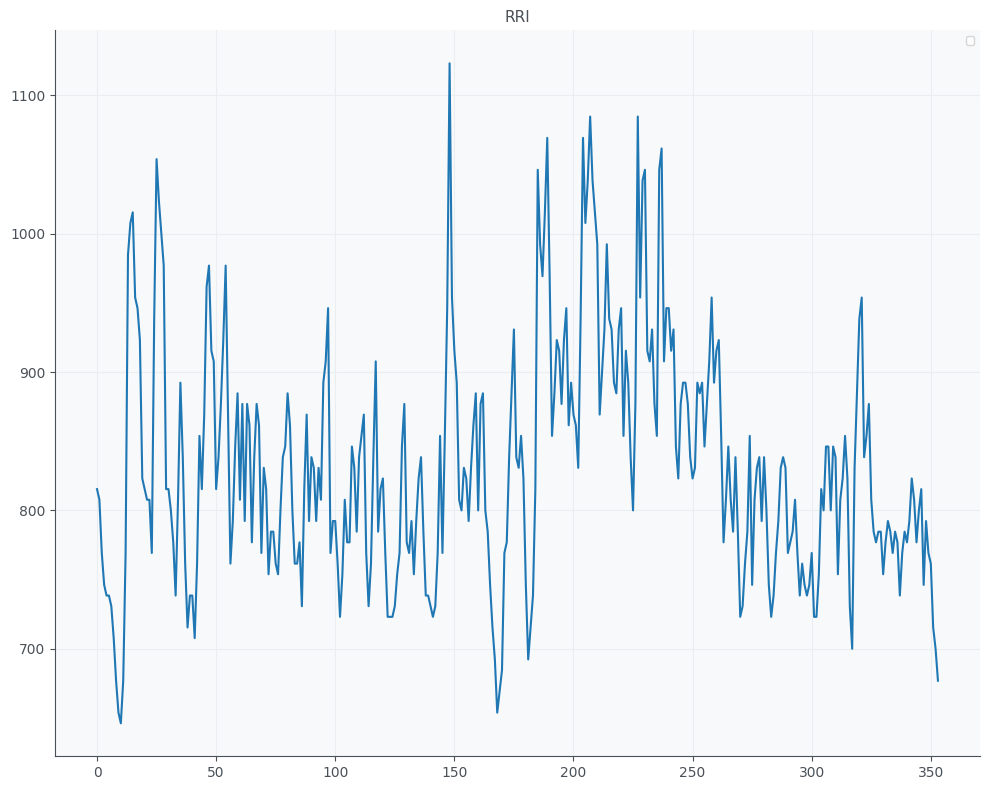

In [56]:
with open('CSV/rri_calm.txt', 'r') as f:
    data = f.read().strip('[]').split()

rri = np.array([float(x) for x in data])

print(rri)
plt.figure(figsize=(10, 8))
plt.plot(rri)
plt.title('RRI')
plt.legend()
plt.tight_layout()
plt.show(block=False)

前処理前のRR間隔(RRI)を期外収縮というアーチファクトがあるかどうかを確認します。<br>
期外収縮とは、出現するべき時点より少し早くR波が出現し、その後のR波は出現すべき部分に位置するので、RR間隔が短くなった後に次に長くなるものです。<br>
この時、RR間隔はスパイクのような動きになります。この期外収縮を処理しないまま、心拍変動解析をしてしまうと、高域(High Frequency)の値が大きくなってしまいます。<br>
そのため、期外収縮が起きている部分は、前後の平均値で線形補間を行います。NNIを計算します。<br>
NN間隔(NNI)とは、正常な心拍間の時間間隔を指し、期外収縮などの不整脈の影響を受けずに心拍変動の本質的な変動を捉えることができます。<br>
ECGからRR間隔(RRI)を計算した際のコードに期外収縮を取り除き、平均値で補間する関数を追加して、NN間隔のcsvを作ります。<br>

In [ ]:
from hrvanalysis import remove_outliers, remove_ectopic_beats, interpolate_nan_values
'''
RR間隔(RRI)の計算
'''

def calculate_rri(signal, sampling_rate):
    # R波のピークの初期検出
    out = ecg.ecg(signal=signal, sampling_rate=sampling_rate, show=False)
    initial_rpeaks = out['rpeaks']

    # R波のピークの補正
    rpeaks_hamilton = ecg.correct_rpeaks(signal=signal, rpeaks=initial_rpeaks, sampling_rate=sampling_rate)

    # RRIの計算（ミリ秒単位）
    rri = np.diff(rpeaks_hamilton) * 1000 / sampling_rate
    return rri


def calculate_nni(raw_rri):
    # 生のRR間隔データから外れ値(outlier)を除去する
    cleaned_rri = remove_outliers(rr_intervals=raw_rri, verbose=True)

    # 外れ値を除去したデータのNaN(欠損値)を線形補間で穴埋めする
    fill_nan_rri = interpolate_nan_values(rr_intervals=cleaned_rri, interpolation_method="linear")

    # 補間済みRR間隔データから異所性心拍(ectopic beat)を除去し、NN間隔を得る
    nn_intervals_list = remove_ectopic_beats(rr_intervals=fill_nan_rri, method="malik")

    # NN間隔のNaN(欠損値)を線形補間で穴埋めする 
    interpolated_nn_intervals = interpolate_nan_values(rr_intervals=nn_intervals_list)
    return interpolated_nn_intervals

#新しいファイルへの書き込み 
new_file_path = 'CSV/nni_calm.txt'
rri_list = []

#Polar H10のサンプリング周波数
fs = 130
# ECGの取得
file_path = 'CSV/ecg_calm.txt'  
ecg_signal = np.loadtxt(file_path)
# RRIの計算
rri_list = calculate_rri(ecg_signal,fs)
rri_list = rri_list[0]
# 際よと最後の値を排除
rri_list = rri_list[1:-1]
print(rri_list)
nni_list = calculate_nni(rri_list)
print(type(nni_list))


# 前処理を全て適用済
with open(new_file_path, 'w') as f:
    f.write(np.array2string(np.array(nni_list), precision=18, separator=' ', suppress_small=True))

作成できたNN間隔(NNI)をplotすると以下のようになります。<br>
生のRR間隔のplotと比較すると、期外収縮であった部分が補間され、全体的に上へのスパイクが少なくなっていることがわかります。<br>


No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


[ 807.69230769  769.23076923  746.15384615  738.46153846  738.46153846
  730.76923077  707.69230769  676.92307692  653.84615385  646.15384615
  676.92307692  769.23076923  888.46153846 1007.69230769 1015.38461538
  953.84615385  946.15384615  923.07692308  823.07692308  815.38461538
  807.69230769  807.69230769  769.23076923  911.53846154 1053.84615385
 1023.07692308 1000.          976.92307692  815.38461538  815.38461538
  800.          776.92307692  738.46153846  807.69230769  892.30769231
  838.46153846  761.53846154  715.38461538  738.46153846  738.46153846
  707.69230769  761.53846154  853.84615385  815.38461538  869.23076923
  961.53846154  976.92307692  915.38461538  907.69230769  815.38461538
  838.46153846  876.92307692  923.07692308  976.92307692  869.23076923
  761.53846154  792.30769231  846.15384615  884.61538462  807.69230769
  876.92307692  792.30769231  876.92307692  861.53846154  776.92307692
  838.46153846  876.92307692  861.53846154  769.23076923  830.76923077
  815.

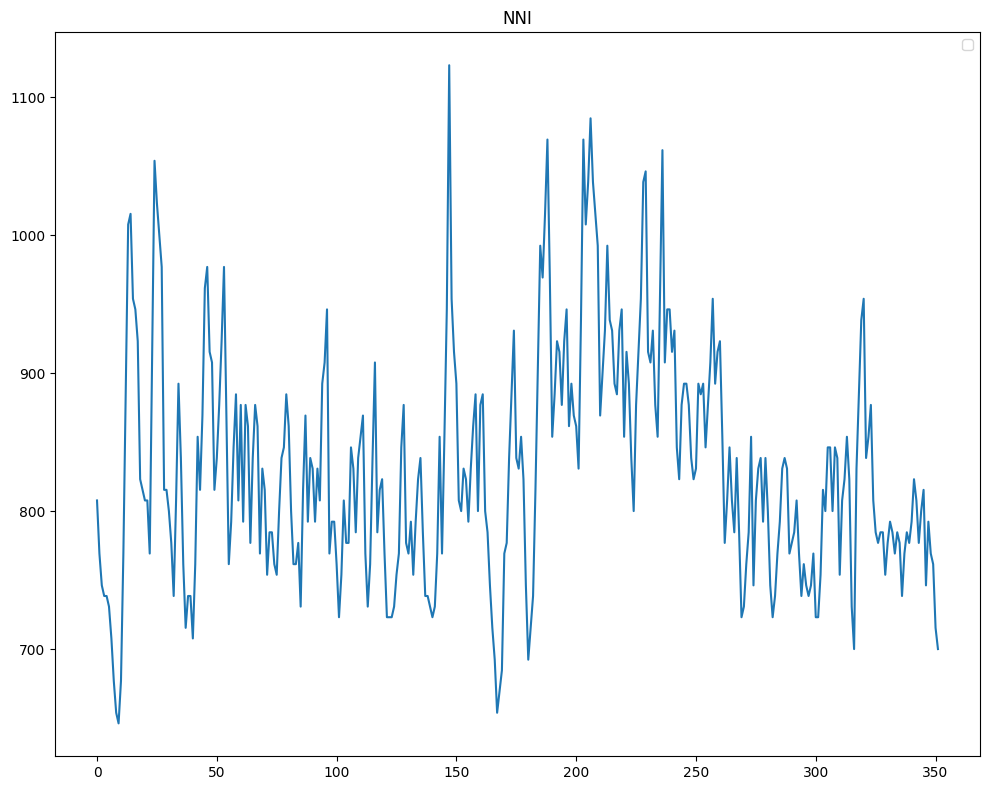

In [10]:
with open('CSV/nni_calm.txt', 'r') as f:
    data = f.read().strip('[]').split()

nni = np.array([float(x) for x in data])

print(nni)
plt.figure(figsize=(10, 8))
plt.plot(nni)
plt.title('NNI')
plt.legend()
plt.tight_layout()
plt.show(block=False)

## 心拍変動解析 (HRV解析)

ついに、心拍変動解析を行なっていきます。
心拍変動解析で取得できる指標は以下のようになっています。
### 心拍変動解析 (HRV解析)で取得できる指標
#### 時間領域指標
RRIから計算できる指標
 *   meanNN: RRI の平均値。
 *   SDNN: RRI の標準偏差。
 *   RMSSD: 隣接する RRI の差の根平均二乗。
 *   Total power: RRI の分散。
 *   NN50: ある時間内に隣接する RRI の差が 50 msecを超えるペアの個数
 *   CVRR: SDNNの値をRRIの平均値で割り、100を掛けた値。
 *   pNN50: 連続して隣接するRRIの差が50msを超える心拍の割合。

#### 周波数領域指標
心拍変動解析を行い、パワースペクトル密度から取得できる指標
 *   LF (低周波数帯域): パワースペクトルの0.04Hz-0.15Hz領域。交感神経と副交感神経の活動を反映する。
 *   HF (高周波数帯域): パワースペクトルの0.15Hz-0.4Hz領域。副交感神経の活動を反映する。
 *   LF/HF: LFとHFの全体バランスを示す。交感神経と副交感神経のバランスを反映する。

しかし、ここでも前処理が必要になります。<br>
心拍変動解析には、スペクトル解析が用いられ、高速フーリエ変換(FFT:Fast Fourier Transform)か、自己回帰モデルによるもの等で行います。<br>
通常、時系列データは時間の単位（例えば秒）で表されるのが望ましいですが、RR間隔をそのまま表した上の図の横軸は「1/拍」で示されてしまっています。<br>
また、今回HRVスペクトル解析で用いる高速フーリエ変換(FFT)は RR間隔が等間隔でないとスペクトル解析を行えません。<br>
そのため、RR間隔を補間し再サンプリングすることで等間隔データに変換した後、FFTなどでスペクトル解析を行います。<br>
まず、横軸を「1/拍」から「時間」へ変換し、FFTを行えるようにします。<br>

In [ ]:
import hrvanalysis
import numpy as np

# 心拍変動解析の適用
def apply_hrv(nni_list):
    hrv_data_list = []
    nni = np.array(nni_list)  # nni_listをNumPy配列に変換
    time_domain_data = hrvanalysis.extract_features.get_time_domain_features(nn_intervals=nni)
    frequency_domain_data = hrvanalysis.extract_features.get_frequency_domain_features(nn_intervals=nni, method='welch', sampling_frequency=4, interpolation_method='linear')
    hrv_data = dict(time_domain_data, **frequency_domain_data)
    hrv_data_list.append([hrv_data])
    return hrv_data_list

with open('CSV/nni_calm.txt', 'r') as f:
    data = f.read().strip('[]').split()
    nni_list = [float(x) for x in data]

# PSDのplot
nni = np.array(nni_list)
hrvanalysis.plot.plot_psd(nni)

nni_hrv = apply_hrv(nni_list)
print(nni_hrv)

time_domain_data = {'mean_nni': 770.5733292079208, 'sdnn': 97.30679746562139, 'sdsd': 63.840611117965544, 'nni_50': 24, 'pnni_50': 11.940298507462687, 'nni_20': 99, 'pnni_20': 49.25373134328358, 'rmssd': 63.941489617979904, 'median_nni': 777.34375, 'range_nni': 909.15625, 'cvsd': 0.0829791107404482, 'cvnni': 0.1262784394129549, 'mean_hr': 387.3512767777768, 'max_hr': 60000.0, 'min_hr': 65.92274678111588, 'std_hr': 4208.867038225538}

frequency_domain_data = {'lf': 623.6226017793806, 'hf': 310.6044260417559, 'lf_hf_ratio': 2.0077711374774303, 'lfnu': 66.7527895477219, 'hfnu': 33.2472104522781, 'total_power': 1886.3879171175097, 'vlf': 952.1608892963733}
1052:~/Desktop/技術書展/2024 (main|✚15…)

パワースペクトル密度をplotすると、以下のようになります。
PSDとは、LF,HFを計算する際の分布です。

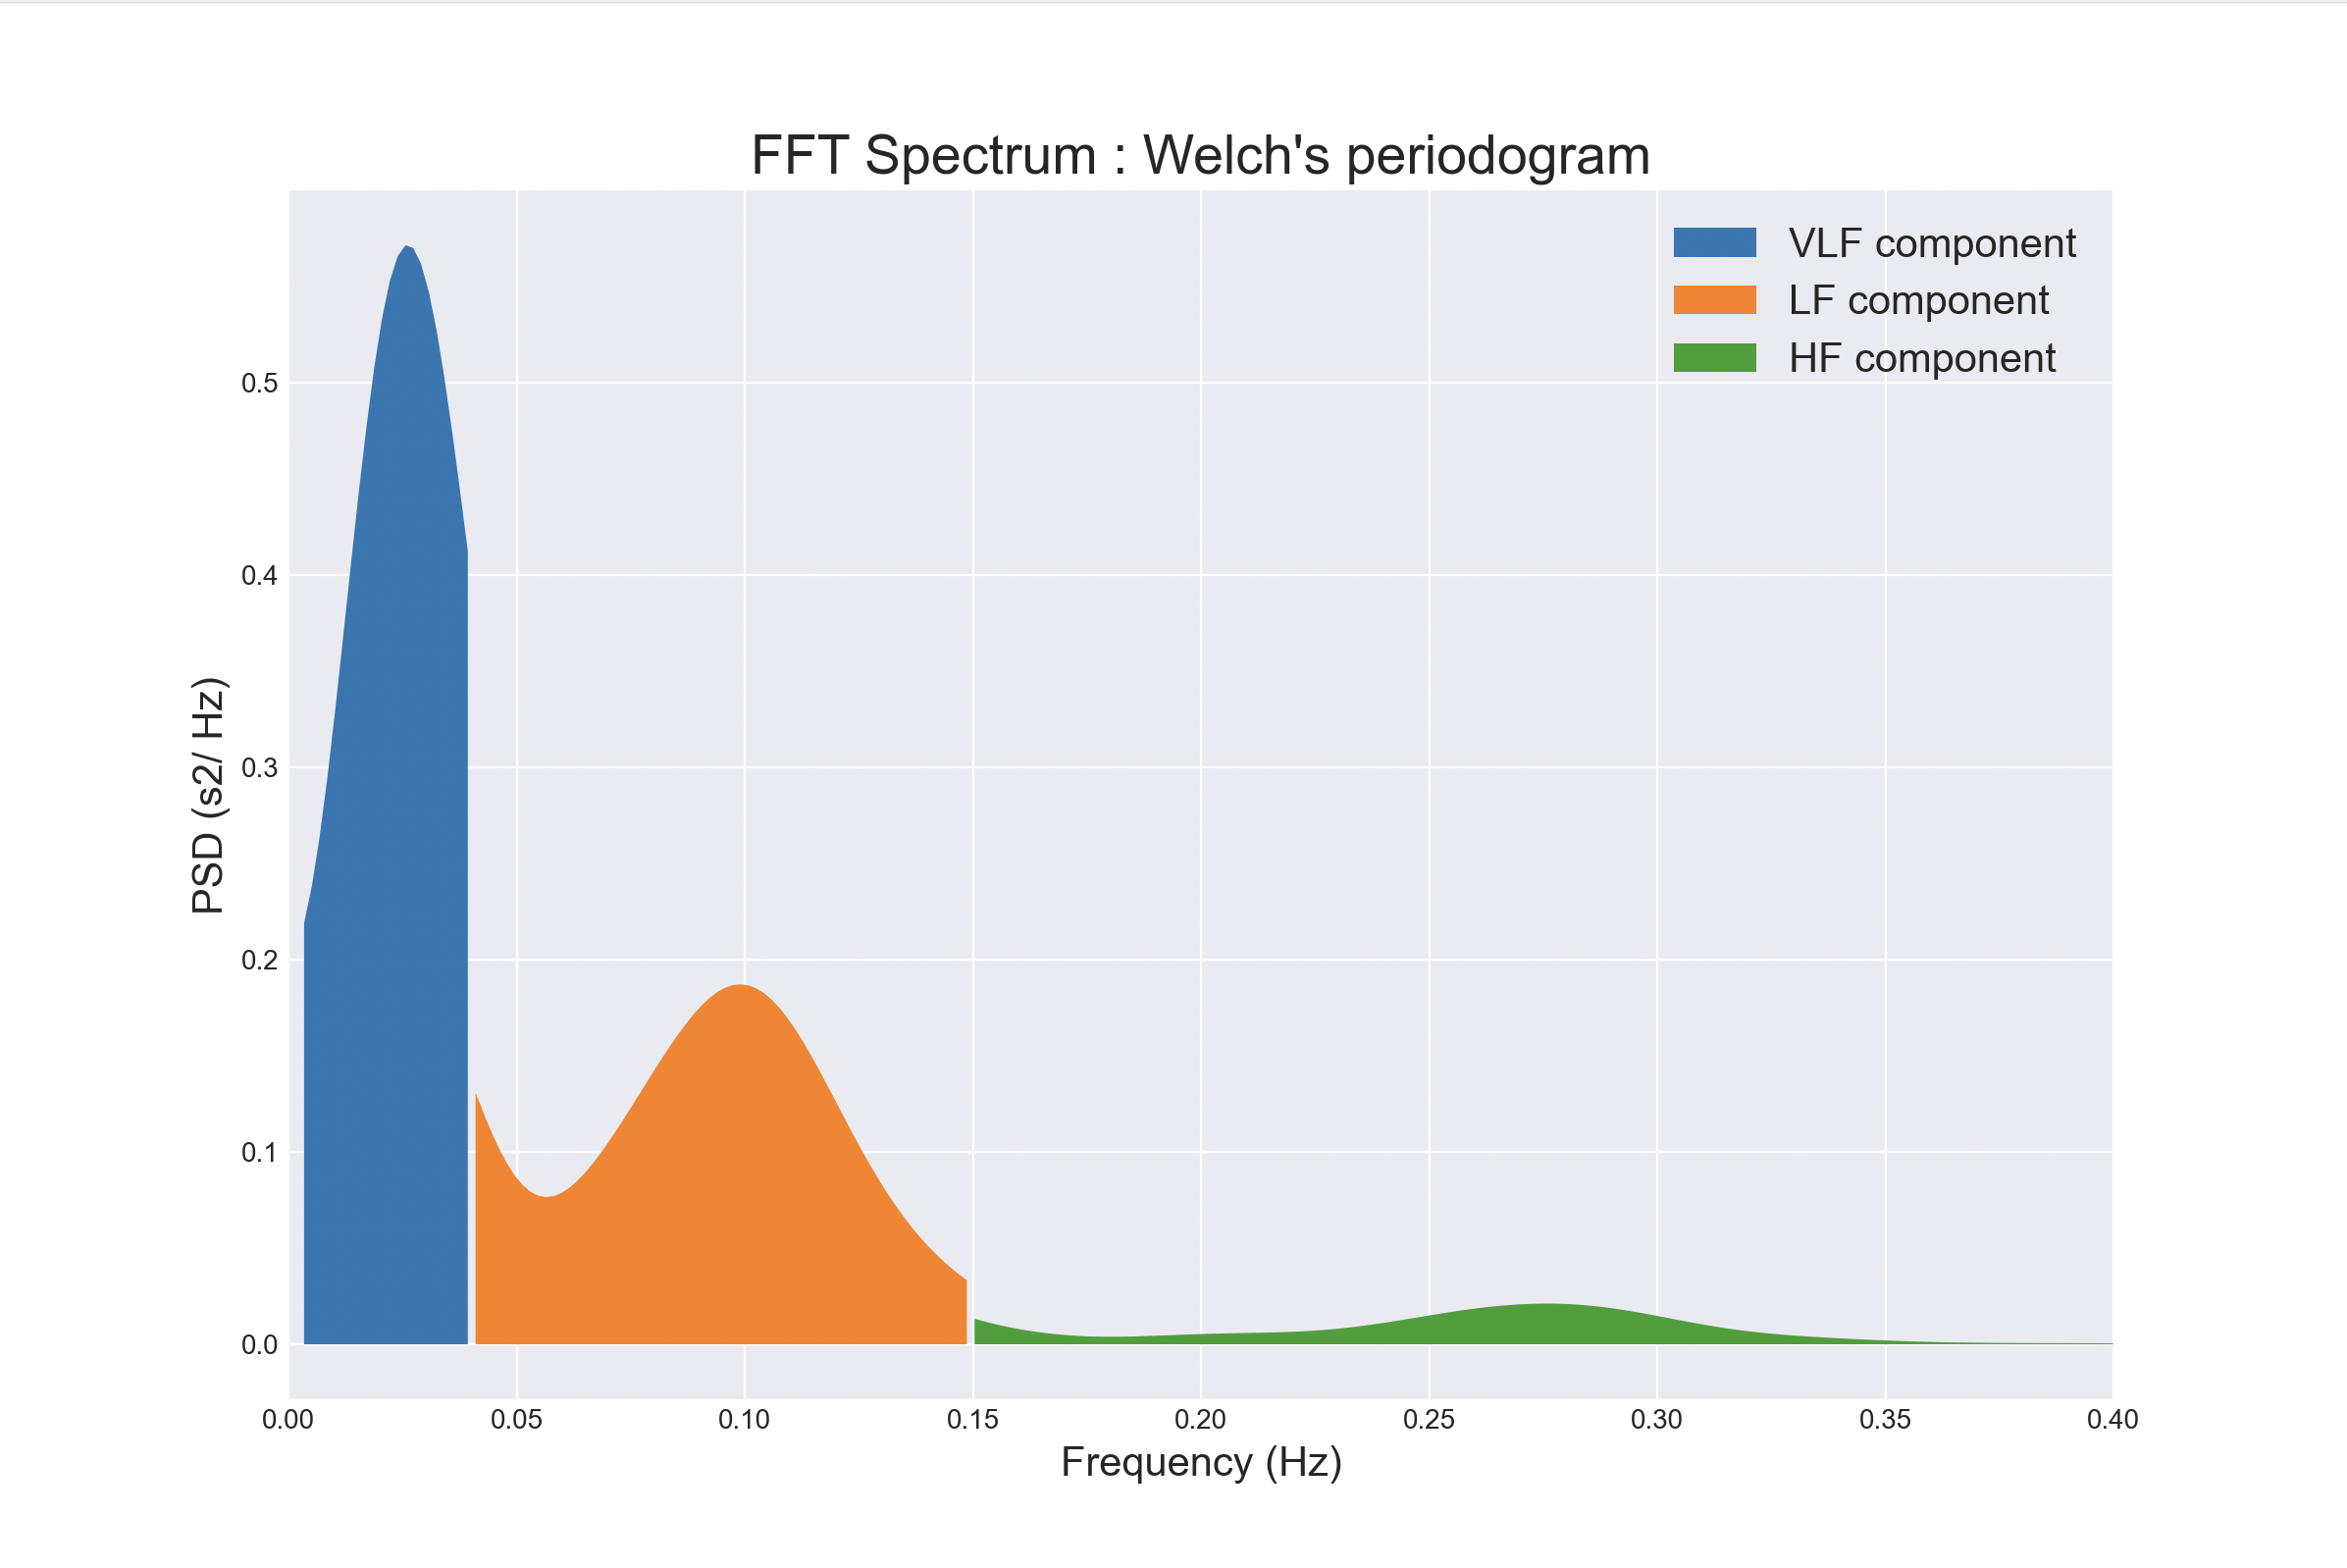


# 疲労・ストレス解析

ここでは、先ほど算出した自律神経の働きを示す心拍変動解析を用いて、疲労・ストレス解析を行います。心拍変動の中でもストレスを表す指標について詳述します。

## 心拍変動解析から得られる主な指標と、それらが示す生理学的意味

### 時間領域指標:
- **SDNN**: 心拍変動の全体的な大きさを反映し、副交感神経活動の指標。ストレス耐性の指標ともされる。
- **RMSSD**: 短期的な副交感神経活動の指標。
- **pNN50**: 心拍変動の大きな変化を捉え、副交感神経緊張の指標。

### 周波数領域指標:
- **LF (低周波数帯域)**: 交感神経と副交感神経の相対的活動を反映。ストレスを受けると低下する。
- **HF (高周波数帯域)**: 副交感神経活動を反映。不安や疲労で低下。
- **LF/HF**: 交感神経と副交感神経のバランスを示す。

### その他の指標:
- **TP (Total Power)**: 自律神経機能全体の活動量を反映。低下は慢性的ストレスを意味する。
- **LFnu、HFnu**: 交感神経、副交感神経それぞれの自律神経活動における相対的寄与度。
- **CCVTP、CCVHF**: 年齢や疲労・ストレスの影響を補正した自律神経機能の指標。

これらの指標を用いて、ストレスや疲労、自律神経のバランス状態を総合的に評価することができます。一般に、ストレスや疲労が蓄積すると副交感神経活動は低下し、交感神経が優位になる傾向にあります。本研究では、これらの変化を捉えて被験者の心身の状態を詳細に分析することが目的です。

特に、**CCVTP** (Component Coefficient of Variance of Total Power) は、総心拍変動量 (TP) の変動成分の大きさを表す指標です。TPは自律神経機能全体の活動量を反映しますが、単純にTP値が高いということは必ずしも良いわけではありません。高心拍数の場合にはTPが高く出る傾向にあるため、CCVTPは、TP値を心拍数で補正した値となっています。CCVTPの値が高いほど、自律神経の調節能力が高く、ストレスや疲労に強い状態であることを示唆します。健康で若い人ほど数値が高く、加齢や慢性的ストレスの蓄積に伴い低下していきます。


In [56]:
import heartpy as hp

def analyze_hr_variability(rri):
    rri = np.array(rri)
    if rri.size < 2:
        return "RRIデータが不足しています。"

    # RRIデータを心拍数データに変換
    hr_data = 60000 / rri

    # RRIデータの差分を取り、サンプリングレートを計算
    rri_diff = np.diff(rri)
    if rri_diff.size == 0 or np.all(rri_diff == 0):
        return "RRIデータの差分が計算できません。データが一定か、不足しています。"

    sampling_rate = 256

    # 心拍変動データの解析
    try:
        wd, m = hp.process(hr_data, sample_rate=sampling_rate)
    except Exception as e:
        return f"解析中にエラーが発生しました: {str(e)}"

    metrics = {
        'SDNN': m.get('sdnn', 'データ不足'),
        'RMSSD': m.get('rmssd', 'データ不足'),
        'pNN50': m.get('pnn50', 'データ不足'),
        'LF': m.get('lf', 'データ不足'),
        'HF': m.get('hf', 'データ不足'),
        'LF/HF ratio': m.get('lf/hf', 'データ不足'),
        'Total Power': m.get('total_power', 'データ不足'),
        'LFnu': m.get('lf_nu', 'データ不足'),
        'HFnu': m.get('hf_nu', 'データ不足'),
        'CCVTP': np.std(rri) / np.mean(rri)
    }

    return metrics

In [63]:
file_path = 'DREAMER_Data/CSV/emotion_nni_v2.csv'
#データの取得
header, data = read_data(file_path=file_path)
nni,arousal_level = extract_and_prepare_features(data,True)
print()
hrv = analyze_hr_variability(nni[2])
print(hrv)


{'SDNN': nan, 'RMSSD': nan, 'pNN50': nan, 'LF': 'データ不足', 'HF': 'データ不足', 'LF/HF ratio': 'データ不足', 'Total Power': 'データ不足', 'LFnu': 'データ不足', 'HFnu': 'データ不足', 'CCVTP': 0.13004691179681963}


/Users/snowyowl/.pyenv/versions/3.10.9/lib/python3.10/site-packages/numpy/core/fromnumeric.py:3504: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/Users/snowyowl/.pyenv/versions/3.10.9/lib/python3.10/site-packages/numpy/core/_methods.py:206: RuntimeWarning: Degrees of freedom <= 0 for slice
  ret = _var(a, axis=axis, dtype=dtype, out=out, ddof=ddof,
/Users/snowyowl/.pyenv/versions/3.10.9/lib/python3.10/site-packages/numpy/ma/core.py:5334: RuntimeWarning: Mean of empty slice.
  result = super().mean(axis=axis, dtype=dtype, **kwargs)[()]
/Users/snowyowl/.pyenv/versions/3.10.9/lib/python3.10/site-packages/numpy/core/fromnumeric.py:3787: RuntimeWarning: Degrees of freedom <= 0 for slice
  return _methods._var(a, axis=axis, dtype=dtype, out=out, ddof=ddof,
